In [ ]:
import numpy as np 
import tensorflow
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy.matlib import repmat
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from scipy import linalg as LA
from sklearn.metrics import rand_score, adjusted_rand_score

In [ ]:
(train_set, train_label), (test_set, test_label) = mnist.load_data()
train_set, train_label = train_set[:20000], train_label[:20000]
train_set.shape

train_set = train_set.reshape(20000,-1)/255
train_set.shape

11501568/11490434 [==============================] - 0s 0us/step


(20000, 784)

In [ ]:
def viewcolumn(columnvector):
    plt.imshow(columnvector.reshape([28, 28], order='F'), cmap=plt.get_cmap('gray'))

def accum(l):
    new_l = []
    cumsum = 0
    for elt in l:
        cumsum += elt
        new_l.append(cumsum)
    return new_l

def calc_cov(X):
  d = float(X.shape[1] - 1)
  cov_out = np.dot(X.T, X.conj()) / d
  return cov_out
  

(-0.5, 27.5, 27.5, -0.5)

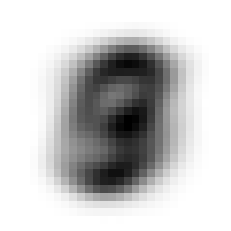

In [ ]:
mean_num = np.mean(train_set, axis=0)
plt.imshow(mean_num.reshape(28, 28), cmap = plt.cm.binary)
plt.axis('off')

In [ ]:
#Calculating PCA
train_ms = np.subtract(train_set, mean_num)

covariance_matrix = calc_cov(train_ms)

eigenvalues, eigenvectors = LA.eigh(covariance_matrix)
decreasing_order = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[decreasing_order]
eigenvectors = eigenvectors[:, decreasing_order]

transformed_data = np.dot(train_ms, eigenvectors)

Text(0.5, 1.0, 'Scree plot of MNIST after PCA')

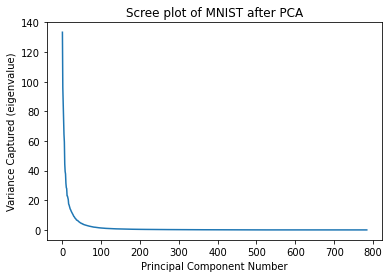

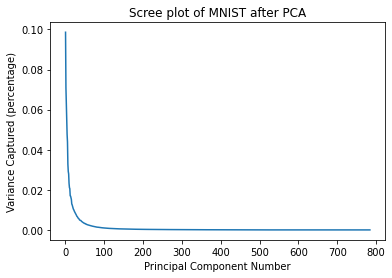

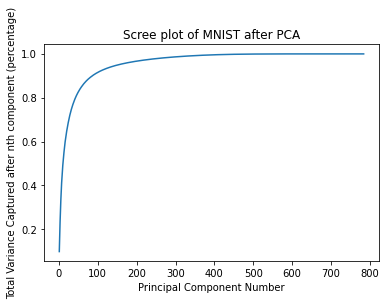

In [ ]:
plt.figure()
plt.plot(np.arange(1, 785), eigenvalues)
plt.xlabel('Principal Component Number')
plt.ylabel('Variance Captured (eigenvalue)')
plt.title('Scree plot of MNIST after PCA')

plt.figure()
plt.plot(np.arange(1, 785), eigenvalues/np.sum(eigenvalues) )
plt.xlabel('Principal Component Number')
plt.ylabel('Variance Captured (percentage)')
plt.title('Scree plot of MNIST after PCA')

cum_eig = accum(eigenvalues/np.sum(eigenvalues))
plt.figure()
plt.plot(np.arange(1, 785), cum_eig)
plt.xlabel('Principal Component Number')
plt.ylabel('Total Variance Captured after nth component (percentage)')
plt.title('Scree plot of MNIST after PCA')

In [ ]:
def calcSqDistances(X, Kmus):
    sqDmat = np.zeros((X.shape[0], Kmus.shape[0]))
    
    for i in range(Kmus.shape[0]):
        sqDmat[:, i] = np.sum((np.abs(X-Kmus[i,  :]))**2, 1)
    
    return sqDmat

def determineRnk(sqDmat):
    Rnk = np.zeros(sqDmat.shape)
    Rnk[np.arange(Rnk.shape[0]), np.argmin(sqDmat, 1)] = 1
    return Rnk

def recalcMus(X, Rnk):
    Kmus = np.zeros((Rnk.shape[1], X.shape[1]))
        
    for i in range(Rnk.shape[1]):
        Kmus[i, :] = np.sum(X[(Rnk[:, i] == 1), :]/np.sum(Rnk[:, i]), 0)
    
    return Kmus

def runKMeans(train_data, K, seed=256):
    N = train_data.shape[0]
    D = train_data.shape[1]
    
    Kmus = np.zeros((K, D))

    rng_gen = np.random.default_rng(seed=seed)
    rand_idxs = rng_gen.choice(N, K, replace=False)

    Kmus = train_data[rand_idxs, :]
    
    maxiter = 1000
    
    for i in tqdm(range(maxiter)):
        sqDmat = calcSqDistances(train_data, Kmus)
        Rnk = determineRnk(sqDmat)
        
        KmusOld = Kmus
        Kmus = recalcMus(train_data, Rnk)
        
        if np.sum(np.abs(KmusOld-Kmus)) < 1e-6:
            print('Finished in {} iterations'.format(i))
            break
        
        cur_it = i

    cluster_groups = np.argmin(sqDmat, 1)
    return Kmus, cluster_groups, cur_it

def get_cluster_plot(Kmus): 
    
    if len(Kmus) == 10:
        fig,axs = plt.subplots(2,5, figsize = (15,9))
    else:
        fig,axs = plt.subplots(4,5, figsize = (15,9))
    
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(28,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')
        axs[i//5][i%5].axis('off')
    fig.tight_layout(pad=2.0)

<Figure size 432x288 with 0 Axes>

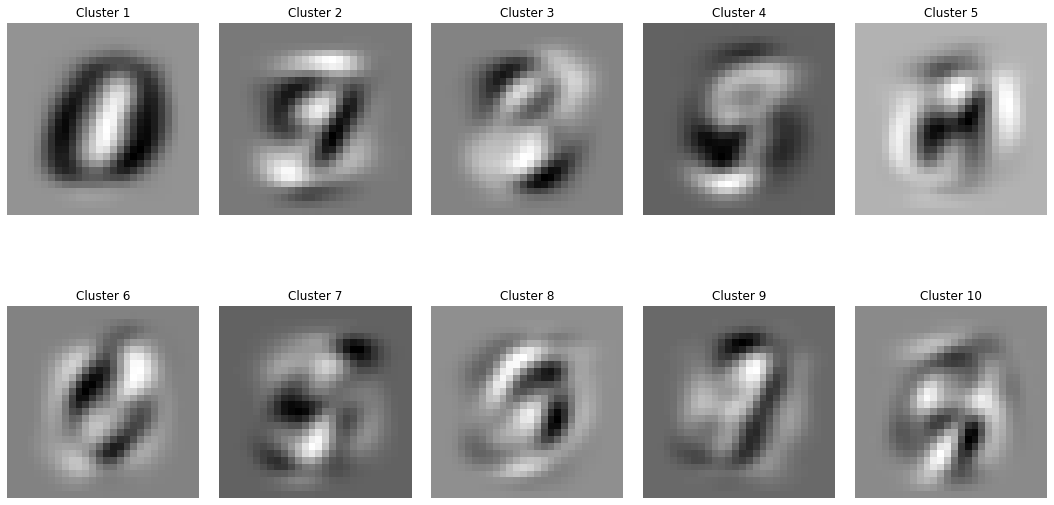

In [ ]:
plt.figure()
get_cluster_plot(eigenvectors[:, :10].T)

In [ ]:
import time

var_expl = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
seeds = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

durations = np.zeros((len(var_expl), len(var_expl)))
iters = np.zeros((len(var_expl), len(var_expl)))
rand_scores = np.zeros((len(var_expl), len(var_expl)))

for j, seed in enumerate(seeds):
    for i, explained in enumerate(var_expl):
        if explained == 1.0:

            start = time.time()
            Kmus, cl, its = runKMeans(transformed_data, 10, seed=seed)
            end = time.time()

            durations[j][i] += (end-start)
            iters[j][i] += its
            rand_scores[j][i] += (adjusted_rand_score(train_label, cl))

        else:

            start = time.time()
            Kmus, cl, its = runKMeans(transformed_data[:, :np.argmax(np.array(cum_eig)>explained)], 10, seed=seed)
            end = time.time()

            durations[j][i] += (end-start)
            iters[j][i] += its
            rand_scores[j][i] += (adjusted_rand_score(train_label, cl))




  8%|▊         | 78/1000 [00:00<00:05, 169.27it/s]


Finished in 78 iterations


  5%|▌         | 51/1000 [00:00<00:16, 56.95it/s]


Finished in 51 iterations


  4%|▍         | 39/1000 [00:00<00:23, 41.74it/s]


Finished in 39 iterations


  2%|▎         | 25/1000 [00:00<00:18, 51.39it/s]


Finished in 25 iterations


  3%|▎         | 31/1000 [00:00<00:22, 42.99it/s]


Finished in 31 iterations


  5%|▍         | 48/1000 [00:01<00:25, 37.01it/s]


Finished in 48 iterations


  7%|▋         | 68/1000 [00:02<00:32, 28.92it/s]


Finished in 68 iterations


  8%|▊         | 77/1000 [00:03<00:47, 19.29it/s]


Finished in 77 iterations


  6%|▌         | 62/1000 [00:07<01:46,  8.83it/s]


Finished in 62 iterations


  7%|▋         | 73/1000 [00:54<11:35,  1.33it/s]


Finished in 73 iterations


  5%|▍         | 48/1000 [00:00<00:05, 170.49it/s]


Finished in 48 iterations


 10%|█         | 101/1000 [00:01<00:13, 67.95it/s]


Finished in 101 iterations


  6%|▌         | 57/1000 [00:00<00:16, 58.69it/s]


Finished in 57 iterations


 11%|█▏        | 114/1000 [00:02<00:16, 52.97it/s]


Finished in 114 iterations


  3%|▎         | 29/1000 [00:00<00:27, 35.85it/s]


Finished in 29 iterations


  8%|▊         | 82/1000 [00:02<00:27, 33.81it/s]


Finished in 82 iterations


  5%|▌         | 50/1000 [00:01<00:33, 28.26it/s]


Finished in 50 iterations


  6%|▌         | 57/1000 [00:02<00:44, 21.17it/s]


Finished in 57 iterations


 11%|█▏        | 114/1000 [00:11<01:25, 10.32it/s]


Finished in 114 iterations


 11%|█         | 107/1000 [01:20<11:12,  1.33it/s]


Finished in 107 iterations


 10%|▉         | 97/1000 [00:00<00:05, 170.25it/s]


Finished in 97 iterations


  6%|▋         | 65/1000 [00:00<00:13, 67.05it/s]


Finished in 65 iterations


  5%|▍         | 46/1000 [00:00<00:15, 60.03it/s]


Finished in 46 iterations


  6%|▌         | 56/1000 [00:01<00:18, 51.88it/s]


Finished in 56 iterations


  4%|▍         | 43/1000 [00:01<00:22, 42.28it/s]


Finished in 43 iterations


  6%|▌         | 58/1000 [00:01<00:25, 37.00it/s]


Finished in 58 iterations


  5%|▍         | 48/1000 [00:01<00:33, 28.02it/s]


Finished in 48 iterations


  6%|▌         | 62/1000 [00:02<00:44, 21.02it/s]


Finished in 62 iterations


  5%|▍         | 48/1000 [00:04<01:33, 10.16it/s]


Finished in 48 iterations


 13%|█▎        | 126/1000 [01:36<11:11,  1.30it/s]


Finished in 126 iterations


 11%|█         | 106/1000 [00:00<00:05, 174.97it/s]


Finished in 106 iterations


  6%|▌         | 55/1000 [00:00<00:13, 68.24it/s]


Finished in 55 iterations


  8%|▊         | 78/1000 [00:01<00:15, 60.35it/s]


Finished in 78 iterations


  4%|▍         | 41/1000 [00:00<00:18, 52.59it/s]


Finished in 41 iterations


  6%|▌         | 60/1000 [00:01<00:21, 43.39it/s]


Finished in 60 iterations


  5%|▌         | 53/1000 [00:01<00:25, 36.77it/s]


Finished in 53 iterations


  6%|▋         | 63/1000 [00:02<00:33, 28.06it/s]


Finished in 63 iterations


  6%|▋         | 64/1000 [00:03<00:44, 21.12it/s]


Finished in 64 iterations


  8%|▊         | 81/1000 [00:08<01:37,  9.43it/s]


Finished in 81 iterations


  8%|▊         | 75/1000 [00:55<11:26,  1.35it/s]


Finished in 75 iterations


  6%|▋         | 64/1000 [00:00<00:05, 170.58it/s]


Finished in 64 iterations


  5%|▍         | 48/1000 [00:00<00:14, 66.97it/s]


Finished in 48 iterations


  5%|▌         | 54/1000 [00:00<00:16, 58.66it/s]


Finished in 54 iterations


  9%|▊         | 87/1000 [00:01<00:17, 53.07it/s]


Finished in 87 iterations


  3%|▎         | 32/1000 [00:00<00:22, 42.70it/s]


Finished in 32 iterations


  5%|▍         | 46/1000 [00:01<00:26, 36.56it/s]


Finished in 46 iterations


  6%|▌         | 57/1000 [00:02<00:33, 28.18it/s]


Finished in 57 iterations


  8%|▊         | 80/1000 [00:03<00:43, 20.94it/s]


Finished in 80 iterations


  5%|▍         | 46/1000 [00:04<01:30, 10.55it/s]


Finished in 46 iterations


  6%|▌         | 57/1000 [00:42<11:45,  1.34it/s]


Finished in 57 iterations


 10%|█         | 102/1000 [00:00<00:05, 170.39it/s]


Finished in 102 iterations


  9%|▉         | 89/1000 [00:01<00:13, 67.75it/s]


Finished in 89 iterations


  8%|▊         | 83/1000 [00:01<00:15, 59.05it/s]


Finished in 83 iterations


  5%|▌         | 52/1000 [00:00<00:17, 52.69it/s]


Finished in 52 iterations


  4%|▍         | 44/1000 [00:01<00:22, 42.85it/s]


Finished in 44 iterations


  6%|▋         | 65/1000 [00:01<00:25, 36.91it/s]


Finished in 65 iterations


 11%|█         | 106/1000 [00:03<00:30, 29.58it/s]


Finished in 106 iterations


  5%|▌         | 50/1000 [00:02<00:45, 20.94it/s]


Finished in 50 iterations


  5%|▍         | 46/1000 [00:04<01:32, 10.30it/s]


Finished in 46 iterations


  5%|▍         | 48/1000 [00:35<11:53,  1.34it/s]


Finished in 48 iterations


  5%|▌         | 54/1000 [00:00<00:05, 170.81it/s]


Finished in 54 iterations


  9%|▊         | 87/1000 [00:01<00:13, 67.83it/s]


Finished in 87 iterations


 16%|█▌        | 158/1000 [00:02<00:13, 60.28it/s]


Finished in 158 iterations


  5%|▍         | 49/1000 [00:00<00:18, 52.33it/s]


Finished in 49 iterations


  9%|▊         | 86/1000 [00:01<00:21, 43.17it/s]


Finished in 86 iterations


  5%|▌         | 50/1000 [00:01<00:25, 36.92it/s]


Finished in 50 iterations


  7%|▋         | 66/1000 [00:02<00:33, 27.82it/s]


Finished in 66 iterations


 11%|█▏        | 113/1000 [00:05<00:42, 20.65it/s]


Finished in 113 iterations


 18%|█▊        | 183/1000 [00:17<01:17, 10.59it/s]


Finished in 183 iterations


 20%|██        | 202/1000 [02:29<09:50,  1.35it/s]


Finished in 202 iterations


  8%|▊         | 77/1000 [00:00<00:05, 178.66it/s]


Finished in 77 iterations


 14%|█▎        | 135/1000 [00:02<00:12, 66.72it/s]


Finished in 135 iterations


  5%|▍         | 49/1000 [00:00<00:16, 58.64it/s]


Finished in 49 iterations


  3%|▎         | 28/1000 [00:00<00:18, 51.40it/s]


Finished in 28 iterations


  6%|▌         | 60/1000 [00:01<00:21, 43.05it/s]


Finished in 60 iterations


  5%|▍         | 49/1000 [00:01<00:25, 36.89it/s]


Finished in 49 iterations


  4%|▎         | 35/1000 [00:01<00:34, 27.89it/s]


Finished in 35 iterations


 21%|██        | 207/1000 [00:09<00:36, 21.44it/s]


Finished in 207 iterations


  3%|▎         | 34/1000 [00:03<01:32, 10.45it/s]


Finished in 34 iterations


  4%|▍         | 45/1000 [00:33<11:50,  1.34it/s]


Finished in 45 iterations


 11%|█▏        | 113/1000 [00:00<00:05, 174.90it/s]


Finished in 113 iterations


  6%|▌         | 60/1000 [00:00<00:13, 67.23it/s]


Finished in 60 iterations


  5%|▌         | 51/1000 [00:00<00:16, 57.80it/s]


Finished in 51 iterations


  4%|▍         | 45/1000 [00:00<00:18, 52.03it/s]


Finished in 45 iterations


  5%|▍         | 49/1000 [00:01<00:22, 43.04it/s]


Finished in 49 iterations


  4%|▍         | 40/1000 [00:01<00:26, 36.65it/s]


Finished in 40 iterations


  5%|▍         | 48/1000 [00:01<00:33, 28.21it/s]


Finished in 48 iterations


  6%|▌         | 55/1000 [00:02<00:44, 21.43it/s]


Finished in 55 iterations


  6%|▌         | 60/1000 [00:05<01:29, 10.49it/s]


Finished in 60 iterations


  8%|▊         | 85/1000 [01:07<12:04,  1.26it/s]


Finished in 85 iterations


  4%|▍         | 43/1000 [00:00<00:05, 168.07it/s]


Finished in 43 iterations


 10%|█         | 100/1000 [00:01<00:13, 68.35it/s]


Finished in 100 iterations


  6%|▋         | 63/1000 [00:01<00:16, 57.47it/s]


Finished in 63 iterations


  3%|▎         | 30/1000 [00:00<00:18, 51.86it/s]


Finished in 30 iterations


  7%|▋         | 67/1000 [00:01<00:21, 42.83it/s]


Finished in 67 iterations


  4%|▎         | 37/1000 [00:01<00:26, 36.28it/s]


Finished in 37 iterations


  6%|▋         | 63/1000 [00:02<00:34, 27.15it/s]


Finished in 63 iterations


  4%|▍         | 39/1000 [00:03<01:20, 11.99it/s]


Finished in 39 iterations


  4%|▍         | 43/1000 [00:04<01:34, 10.17it/s]


Finished in 43 iterations


  4%|▍         | 41/1000 [00:32<12:39,  1.26it/s]

Finished in 41 iterations


In [ ]:
dur_mu= np.mean(durations, axis=0)
it_mu = np.mean(iters, axis=0)
rs_mu = np.mean(rand_scores, axis=0)

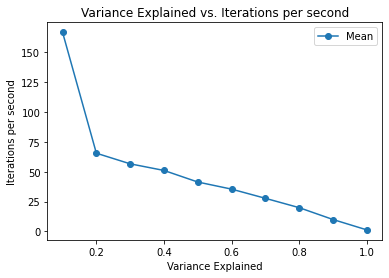

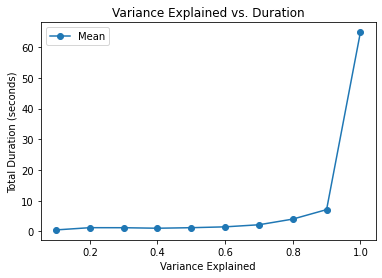

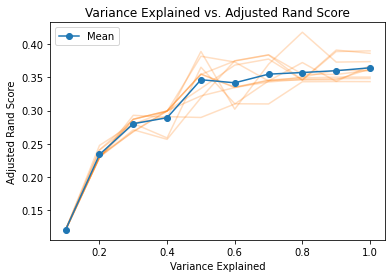

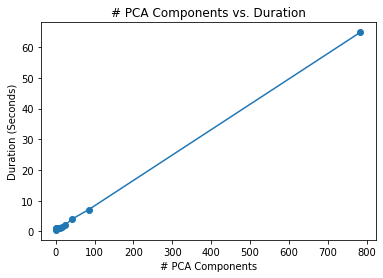

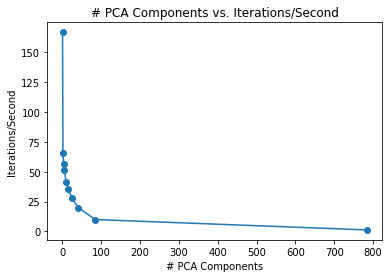

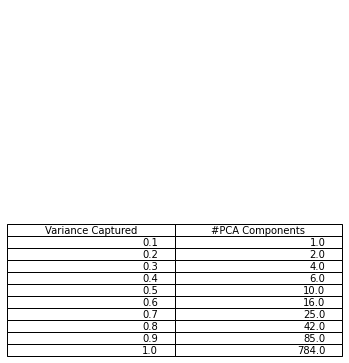

In [ ]:
#for i in range(10):
  #plt.plot(var_expl, np.divide(np.array(iters[i, :]),np.array(durations[i, :])),"tab:orange", alpha=0.25)
plt.plot(var_expl, np.divide(it_mu,dur_mu), marker='o', label="Mean")
plt.legend()
plt.title('Variance Explained vs. Iterations per second')
plt.xlabel('Variance Explained')
plt.ylabel('Iterations per second')

plt.figure()
#for i in range(10):
  #plt.plot(var_expl, durations[i, :],"tab:orange", alpha=0.25)
plt.plot(var_expl, dur_mu, marker='o', label="Mean")
plt.legend()
plt.title('Variance Explained vs. Duration')
plt.xlabel('Variance Explained')
plt.ylabel('Total Duration (seconds)')


plt.figure()
for i in range(10):
  plt.plot(var_expl, rand_scores[i, :], "tab:orange", alpha=0.25)
plt.plot(var_expl, rs_mu, marker='o', label="Mean")
plt.legend()
plt.title('Variance Explained vs. Adjusted Rand Score')
plt.xlabel('Variance Explained')
plt.ylabel('Adjusted Rand Score')


plt.figure()
num_pca_comp = []

for expl in var_expl:
  num_pca_comp.append(np.argmax(np.array(cum_eig)>expl))

num_pca_comp[-1] = 784

plt.plot(num_pca_comp, dur_mu, marker='o')
plt.title('# PCA Components vs. Duration')
plt.ylabel('Duration (Seconds)')
plt.xlabel('# PCA Components')

plt.figure()
plt.plot(num_pca_comp,np.divide(it_mu,dur_mu), marker='o')
plt.title('# PCA Components vs. Iterations/Second')
plt.ylabel('Iterations/Second')
plt.xlabel('# PCA Components')

plt.figure()
plt.axis('off')
plt.axis('tight')
plt.table(np.array([var_expl, num_pca_comp]).transpose(), colLabels=['Variance Captured', '#PCA Components'])

In [ ]:
Kmus_100, cl_100, _ = runKMeans(transformed_data, 10)

Kmus_50, cl_50, _ = runKMeans(transformed_data[:, :np.argmax(np.array(cum_eig)>0.5)], 10)

Kmus_10, cl_10, _ = runKMeans(transformed_data[:, :np.argmax(np.array(cum_eig)>0.1)], 10)

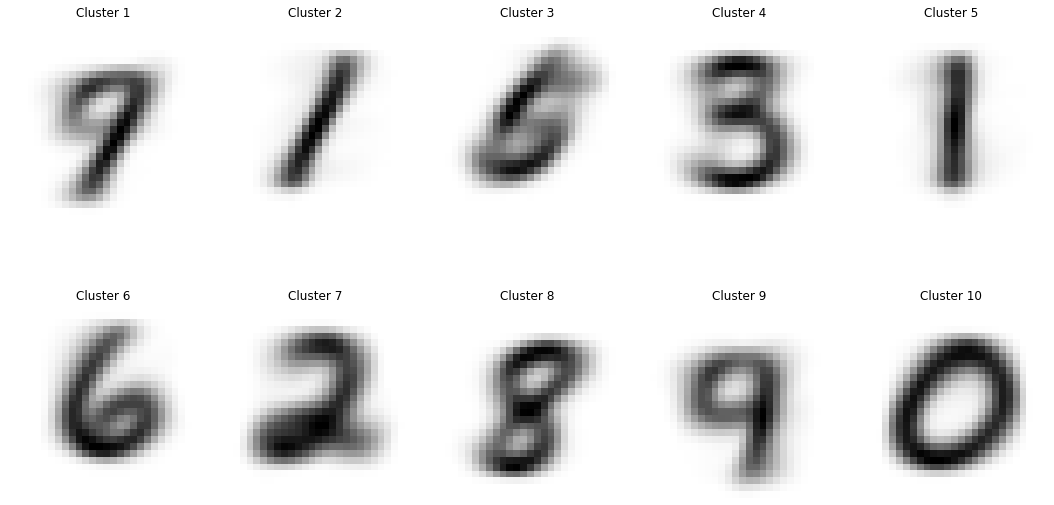

<Figure size 432x288 with 0 Axes>

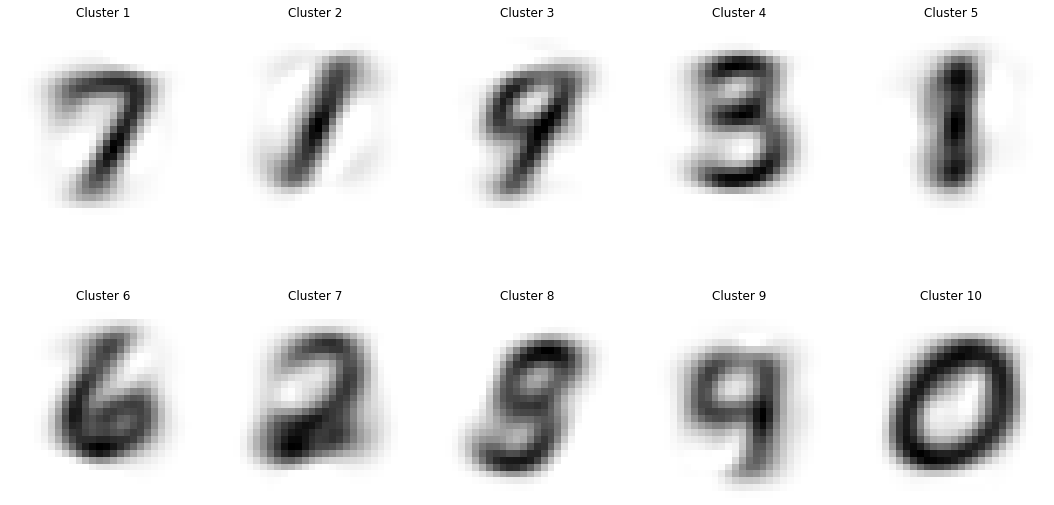

<Figure size 432x288 with 0 Axes>

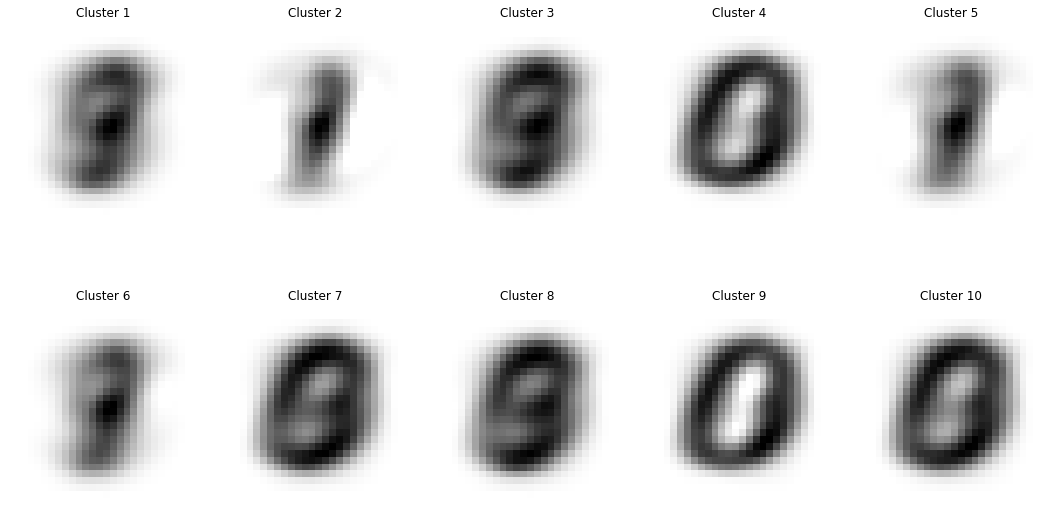

In [ ]:
def reconstruct_PCA(pca_scores, eigvects, mu):
    original = np.dot(pca_scores, (eigvects[:, :pca_scores.shape[1]]).T) + mu
    return original

orig_mus100 = reconstruct_PCA(Kmus_100, eigenvectors, mean_num)
get_cluster_plot(orig_mus100)

orig_mus50 = reconstruct_PCA(Kmus_50, eigenvectors, mean_num)
plt.figure()
get_cluster_plot(np.clip(orig_mus50, a_min=0, a_max=1))

orig_mus5= reconstruct_PCA(Kmus_10, eigenvectors, mean_num)
plt.figure()
get_cluster_plot(np.clip(orig_mus5, a_min=0, a_max=1))